In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_tree,to_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
from xgboost import XGBRegressor

In [3]:
sns.set(style="darkgrid") #configure seaborn

## 1. Introduction
In this analysis I will try find out whether ESG (environment, social, governance) can be use for for predicting fund/ETF return. It is comprised of

Analysis of the ESG data
Applying a neural net to see whether it can improve on optimal guessing
Separate analysis of funds, ETFs and the combined dataset
Disclaimer: this is just an exploratory analysis made out of interest and curiosity and should not be used for any investment dicisions whatsoever.

### 1.1 Weaknesses in the Analysis

There are several factors which could be adjusted for, e.g. sectors, regions etc
No risk-adjustment
Short time horizon: a more complete analysis would look into the correlation over a longer time, in order to consider:
Structural changes in the economy
Market trends
Changes before and after important events such as the financial crisis and covid-19 etc.
I might expand the analysis to include more features in the future to try to account for some of this.

## 2. Import Data
Import ESG data
Remove NaN values, we don't want to contaminate the analysis with missing data. I found several instances of NaN while inspecting the data. so the null values were droped instead of filled with any values.

In [4]:
cols = ['isin','fund_trailing_return_ytd', 'social_score', 'environmental_score', 'governance_score', 'sustainability_score']
etf_return_esg = pd.read_csv('Morningstar_European_ETFs.csv', usecols=cols).dropna()

### 2.1 Inspect Data

We start off by having a quick look at the data to:

Identify the format
Spot potential errros
Spot patterns or considerations we might have missed

In [5]:
etf_return_esg.head()

,isin,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
0,CH0008899764,3.37,10.65,8.42,22.44,8.69
1,SE0000693293,3.79,8.61,8.12,20.52,17.61
2,DE000A0H08N1,4.45,7.41,6.97,18.91,8.90
4,IE0032523478,4.45,10.25,8.94,23.95,8.39
5,IE0032895942,3.76,11.56,8.58,24.64,9.26


One of the first things to notice is that sustainability seems to be a sum of the ESG scores. We do a simple check below

In [6]:
esg_cols = ['social_score', 'environmental_score', 'governance_score']
esg_sum = etf_return_esg[esg_cols].sum(axis=1)
df_esg_sum = esg_sum.to_frame('esg_sum')
df = etf_return_esg.join(df_esg_sum)

df[['isin', 'esg_sum','sustainability_score']].head()

,isin,esg_sum,sustainability_score
0,CH0008899764,22.44,22.44
1,SE0000693293,20.52,20.52
2,DE000A0H08N1,18.83,18.91
4,IE0032523478,23.64,23.95
5,IE0032895942,23.90,24.64


And find that it is not true for all but they seem similar, enought that we look into it in the Appendix, but in short it does not seem to be the same data. Thus I keep it as a feature.

## 3. Return and ESG
In this section we try to find out whether ESG is useful in predicting the YTD return. I chose YTD return since I don't have historic ESG data, thus comparing returns for e.g. 2017 might not be relevant.

### 3.1 Independent Correlation

First we check the correlation matrix to see whether ther is any correlation between the ESG data and the YTD return. This is simply to spot any obvious correlation.

The YTD return seems independent for both funds and ETFs. It is close to zero for all. The only exception seems to be environmental score which had a weak negative correlation for ETFs.

However this is under the assumption that the variables are independent, which they are not as the matrix clearly shows. Thus we still might discover something if we try to dig further.

In [7]:
etf_return_esg.corr()

,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
environmental_score,1.000000,0.441917,0.394837,0.699947,-0.284219
social_score,0.441917,1.000000,0.801602,0.594261,0.079225
governance_score,0.394837,0.801602,1.000000,0.442734,-0.024173
sustainability_score,0.699947,0.594261,0.442734,1.000000,-0.150258
fund_trailing_return_ytd,-0.284219,0.079225,-0.024173,-0.150258,1.000000


<AxesSubplot:>

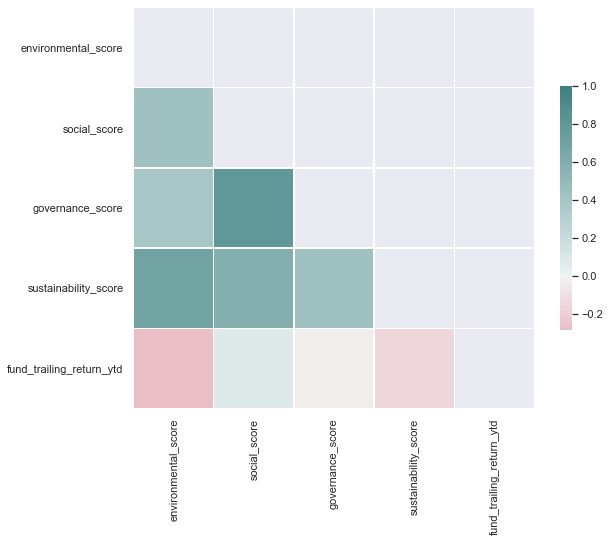

In [20]:
corr = etf_return_esg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(5, 190, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ETFs it's a bit more mixed, there the correlation is  0.4−0.8
We plot some correlations below, but first we must add a flag to make the ETF data distinct from the fund data. We also notice that there seems to be different biases in the data, ETFs have lower values.

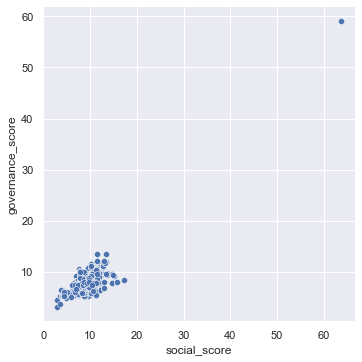

In [20]:
sns.relplot(x='social_score', y='governance_score',  data=etf_return_esg)

### 3.2 Regression Model for the Fund Case

We start out by doing a regression model for the fund case.

First convert the data to numpy arrays, y is what we want to predict, i.e. YTD returns. x are the features.

In [29]:
np_data = np.array(etf_return_esg)
x = np.float32(np_data[:,1:-1])
y = np.float32(np_data[:,-1])

optimal_guessing = np.mean(y)
optimal_guessing_mean_accuracy = np.mean(abs(y-optimal_guessing))
print("Optimal guessing mean accuracy: ", optimal_guessing_mean_accuracy)

Optimal guessing mean accuracy:  9.902584


Create the regression model. I choose a pretty standard xgboosting regression tree.

In [31]:
etf_return_esg.columns

Index(['isin', 'environmental_score', 'social_score', 'governance_score',
       'sustainability_score', 'fund_trailing_return_ytd'],
      dtype='object')

In [32]:
X = etf_return_esg.drop(["isin","fund_trailing_return_ytd"], axis=1)
Y = etf_return_esg["fund_trailing_return_ytd"]

X, X_Val, Y, Y_Val = train_test_split(X, Y)

In [38]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X, Y)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [49]:
grid.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 4,
 'min_child_weight': 4,
 'subsample': 1.0}

In [53]:
xgb = XGBRegressor(colsample_bytree=1.0,gamma=0.5,max_depth=4,min_child_weight=4,subsample=1.0) 
xgb.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
# Print the r2 score
print(r2_score(Y_Val, grid.best_estimator_.predict(X_Val))) 
print(mean_absolute_error(Y_Val, grid.best_estimator_.predict(X_Val)))

0.8458264255699373
2.503048926884045
